
 
# **QUESTÃO 2 PROJETO AM_2019**

> Base de dados:  [Image segmentation](http://archive.ics.uci.edu/ml/datasets/image+segmentation); Tabela com 2100 objetos e 7 classes. cada objeto tem 19 variáveis onde as 9 primeiras sao o Shape View e as 10 ultimas RGB View 


* Test data: 2100; Training Data: 210
* 19 continuos attributes
* Classes:  brickface, sky, foliage, cement, window, path, grass.






# **ABOUT** **DATA**


1. Title: Image Segmentation data

2. Source Information
   -- Creators: Vision Group, University of Massachusetts
   -- Donor: Vision Group (Carla Brodley, brodley@cs.umass.edu)
   -- Date: November, 1990
 
3. Past Usage: None yet published

4. Relevant Information:

   The instances were drawn randomly from a database of 7 outdoor 
   images.  The images were handsegmented to create a classification
   for every pixel.  

   Each instance is a 3x3 region.

5. Number of Instances: Training data: 210  Test data: 2100

6. Number of Attributes: 19 continuous attributes

7. Attribute Information:

    1.  region-centroid-col:  the column of the center pixel of the region.
    2.  region-centroid-row:  the row of the center pixel of the region.
    3.  region-pixel-count:  the number of pixels in a region = 9.
    4.  short-line-density-5:  the results of a line extractoin algorithm that 
         counts how many lines of length 5 (any orientation) with
         low contrast, less than or equal to 5, go through the region.
    5.  short-line-density-2:  same as short-line-density-5 but counts lines
         of high contrast, greater than 5.
    6.  vedge-mean:  measure the contrast of horizontally
         adjacent pixels in the region.  There are 6, the mean and 
         standard deviation are given.  This attribute is used as
        a vertical edge detector.
    7.  vegde-sd:  (see 6)
    8.  hedge-mean:  measures the contrast of vertically adjacent
          pixels. Used for horizontal line detection. 
    9.  hedge-sd: (see 8).
    10. intensity-mean:  the average over the region of (R + G + B)/3
    11. rawred-mean: the average over the region of the R value.
    12. rawblue-mean: the average over the region of the B value.
    13. rawgreen-mean: the average over the region of the G value.
    14. exred-mean: measure the excess red:  (2R - (G + B))
    15. exblue-mean: measure the excess blue:  (2B - (G + R))
    16. exgreen-mean: measure the excess green:  (2G - (R + B))
    17. value-mean:  3-d nonlinear transformation
         of RGB. (Algorithm can be found in Foley and VanDam, Fundamentals
         of Interactive Computer Graphics)
    18. saturatoin-mean:  (see 17)
    19. hue-mean:  (see 17)

8. Missing Attribute Values: None

9. Class Distribution: 

   Classes:  brickface, sky, foliage, cement, window, path, grass.

   30 instances per class for training data.
   300 instances per class for test data.


# **Imports**


In [0]:
#!pip uninstall matplotlib==3.1.1
#!pip install matplotlib==3.0.3

from scipy.spatial.distance import pdist, squareform
import scipy as scip
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import numpy

from numpy.random import seed, randn
from scipy.stats import wilcoxon
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Carregar e inicalizar dados

In [0]:
TRAIN_DATA_URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.data"
TEST_DATA_URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.test"


# Dados para treinamento a serem comparados
train_file_path = tf.keras.utils.get_file("segmentation.data.csv", TRAIN_DATA_URL) #210
# Dados de teste para classificação
test_file_path = tf.keras.utils.get_file("segmentation.test", TEST_DATA_URL) #2100

In [0]:
# Reduce memory usage
def get_optimized_column(column):
    if not np.issubdtype(column.dtypes, np.number):
        return column
    integers = [np.int8, np.int16, np.int32, np.int64]
    floats = [np.float16, np.float32, np.float64]
    max = column.max()
    relevant_types = integers if np.issubdtype(column.dtypes, np.integer) else floats
    for dtype in relevant_types:
        if dtype(max) == max:
            return column.astype(dtype)
    return column


def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        df[column] = get_optimized_column(df[column]) 
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
train_dataset = pd.read_csv(train_file_path, skiprows=2)
test_dataset = pd.read_csv(test_file_path, skiprows=2)

target_labels = {'BRICKFACE': 0, 'SKY': 1, 'FOLIAGE': 2, 'CEMENT': 3, 'WINDOW': 4, 'PATH': 5, 'GRASS': 6}
# 0 = Brickface - 1 = Sky - 2 = Foliage 
# 3 = Cement - 4 = Window - 5 = Path - 6 = Grass

Y_train = train_dataset.index.map(lambda v: target_labels[v])
Y_test = test_dataset.index.map(lambda v: target_labels[v])

train_dataset.head()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
BRICKFACE,140.0,125.0,9,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
BRICKFACE,188.0,133.0,9,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
BRICKFACE,105.0,139.0,9,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
BRICKFACE,34.0,137.0,9,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
BRICKFACE,39.0,111.0,9,0.0,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


In [0]:
Y_test

Int64Index([6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
            ...
            4, 4, 4, 3, 3, 3, 3, 3, 3, 3],
           dtype='int64', length=2100)

In [0]:
shape_view = train_dataset.drop(labels=['REGION-PIXEL-COUNT'], axis=1).columns[:8]
rgb_view = train_dataset.columns[10:]

scaler = Normalizer()

columns = train_dataset.columns

train_dataset = scaler.fit_transform(train_dataset)
test_dataset = scaler.fit_transform(test_dataset)

train_dataset = pd.DataFrame(train_dataset, columns=columns)
test_dataset = pd.DataFrame(test_dataset, columns=columns)

train_dataset[shape_view].describe()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,0.524150,0.581326,0.000040,0.000030,0.008880,0.014086,0.011711,0.026778
std,0.261908,0.274528,0.000153,0.000154,0.014200,0.059748,0.020389,0.100745
min,0.002831,0.031598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.308704,0.404260,0.000000,0.000000,0.003074,0.001633,0.003465,0.002124
50%,0.557772,0.622058,0.000000,0.000000,0.005369,0.003348,0.006493,0.003968
75%,0.744924,0.802862,0.000000,0.000000,0.009710,0.008554,0.011354,0.008847
max,0.987085,0.997188,0.001228,0.001232,0.144189,0.757185,0.159495,0.915415


In [0]:
train_dataset[rgb_view].describe()

,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,0.129320,0.176306,0.132406,-0.050072,0.090886,-0.040814,0.179941,0.002286,-0.006944
std,0.116456,0.145075,0.119494,0.043971,0.074716,0.051690,0.142337,0.001923,0.007825
min,0.000000,0.000000,0.000000,-0.166586,-0.047497,-0.220147,0.000000,0.000000,-0.025363
25%,0.033627,0.047730,0.023767,-0.072857,0.022581,-0.071162,0.054583,0.001040,-0.011004
50%,0.106704,0.164182,0.108528,-0.047044,0.093075,-0.043612,0.166573,0.001669,-0.007983
75%,0.193240,0.268553,0.187544,-0.020627,0.143645,-0.017092,0.268553,0.002953,-0.006317
max,0.420972,0.479559,0.426234,0.040542,0.281210,0.086302,0.479559,0.009850,0.013759


# knn

In [0]:
parameters = {'n_neighbors': np.arange(1,10)} 

knn = KNeighborsClassifier(p=2)

kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=30)

X_shape = reduce_mem_usage(train_dataset[shape_view])
X_rgb = reduce_mem_usage(train_dataset[rgb_view])

grid_shape = GridSearchCV(knn, parameters, cv=kfold, scoring='accuracy')
grid_shape.fit(X_shape, Y_train)
grid_rgb = GridSearchCV(knn, parameters, cv=kfold, scoring='accuracy')
grid_rgb.fit(X_rgb, Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mem. usage decreased to  0.01 Mb (0.0% reduction)
Mem. usage decreased to  0.01 Mb (0.0% reduction)


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f28eea01ef0>,
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
#-----------------Predictions Functions--------------
best_knn_for_shape = grid_shape.best_estimator_
best_knn_for_rgb = grid_rgb.best_estimator_

#Test predict (using train dataset)
Y_pred_shape = best_knn_for_shape.predict(X_shape)
Y_pred_rgb = best_knn_for_rgb.predict(X_rgb)

Shape_test = reduce_mem_usage(test_dataset[shape_view])
Rgb_test = reduce_mem_usage(test_dataset[rgb_view])

Shape_score = best_knn_for_shape.score(Shape_test, Y_test)
Rgb_score = best_knn_for_rgb.score(Rgb_test, Y_test)

print(Shape_score)
print(Rgb_score)
print('SHAPE', grid_shape.best_params_)
print('RGB', grid_rgb.best_params_)


Shape_pred = best_knn_for_shape.predict(Shape_test)
Rgb_pred = best_knn_for_rgb.predict(Rgb_test)

0.5057142857142857
0.8633333333333333
SHAPE {'n_neighbors': 6}
RGB {'n_neighbors': 1}


Confusion Matrix for shape:



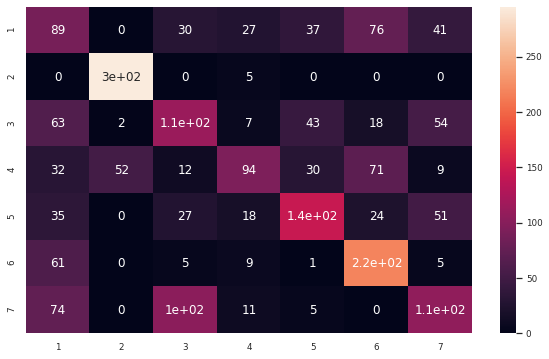



Accuracy Score Shape:  0.5057142857142857

Classification Report SHAPE:
               precision    recall  f1-score   support

           0       0.25      0.30      0.27       300
           1       0.85      0.98      0.91       300
           2       0.39      0.38      0.38       300
           3       0.55      0.31      0.40       300
           4       0.56      0.48      0.52       300
           5       0.54      0.73      0.62       300
           6       0.40      0.36      0.38       300

    accuracy                           0.51      2100
   macro avg       0.50      0.51      0.50      2100
weighted avg       0.50      0.51      0.50      2100



Confusion Matrix for RGB:



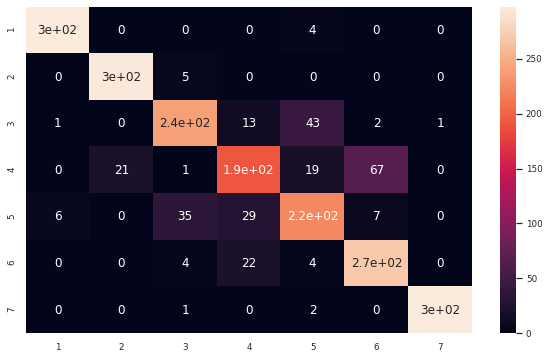

Accuracy Score RGB:  0.8633333333333333

Classification Report RGB:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       300
           1       0.93      0.98      0.96       300
           2       0.84      0.80      0.82       300
           3       0.75      0.64      0.69       300
           4       0.76      0.74      0.75       300
           5       0.78      0.90      0.84       300
           6       1.00      0.99      0.99       300

    accuracy                           0.86      2100
   macro avg       0.86      0.86      0.86      2100
weighted avg       0.86      0.86      0.86      2100



In [0]:
#-------------Confusion Matrix SHAPE---------------------

conf_matrix_shape = confusion_matrix(Y_test, Shape_pred)
print("Confusion Matrix for shape:\n")
df_cm_shape = pd.DataFrame(conf_matrix_shape, index = [i for i in "1234567"],
                      columns = [i for i in "1234567"])
plt.figure(figsize = (10,6))
sns.set(font_scale=0.8)
subplot = sns.heatmap(df_cm_shape, annot=True,annot_kws={"size": 12})# font size
subplot.set_ylim(7, 0)
plt.show()
#------------Accuracy Score SHAPE------------------------
print("\n\nAccuracy Score Shape: ", (accuracy_score(Y_test, Shape_pred)))
print("\nClassification Report SHAPE:\n", (classification_report(Y_test, Shape_pred)))

# #-------------Confusion Matrix RGB---------------------
conf_matrix_rgb = confusion_matrix(Y_test, Rgb_pred)
print("\n\nConfusion Matrix for RGB:\n")
df_cm_rgb = pd.DataFrame(conf_matrix_rgb, index = [i for i in "1234567"],
                      columns = [i for i in "1234567"])
plt.figure(figsize = (10,6))
sns.set(font_scale=0.8)
subplot = sns.heatmap(df_cm_rgb, annot=True,annot_kws={"size": 12})# font size
subplot.set_ylim(7, 0)
plt.show()

# #------------Accuracy Score RGB------------------------
print("Accuracy Score RGB: ", (accuracy_score(Y_test, Rgb_pred)))
print("\nClassification Report RGB:\n", (classification_report(Y_test, Rgb_pred)))

In [0]:
class CombinedClassifiers:
  """
  Classe que combina dois classificadores correspondentes a duas views do dataset
  """
  def __init__(self, first_clf, second_clf, first_view, second_view, L, p_w):
    self.first_clf = first_clf
    self.second_clf = second_clf
    self.first_view = first_view
    self.second_view = second_view
    self.L = L
    self.p_w = p_w

  def predict(self, X_dataset):
    predict_fst = self.first_clf.predict_proba(X_dataset[self.first_view])
    predict_snd = self.second_clf.predict_proba(X_dataset[self.second_view])

    predictions = []
    for post_fst, post_snd in zip(predict_fst, predict_snd):
      classes = (1-self.L) * self.p_w + post_fst + post_snd
      predictions.append(np.argmax(classes))

    return predictions

  def predict_proba(self, X_dataset):
    predict_fst = self.first_clf.predict_proba(X_dataset[self.first_view])
    predict_snd = self.second_clf.predict_proba(X_dataset[self.second_view])

    predictions = []
    for post_fst, post_snd in zip(predict_fst, predict_snd):
      classes = (1-self.L) * self.p_w + post_fst + post_snd
      predictions.append(classes)

    return predictions    

In [0]:
p_w = [0, 0, 0, 0, 0, 0, 0]
for v in Y_test:
  p_w[v] += 1

for i in range(len(p_w)):
  p_w[i] /= len(Y_test)  

p_w = np.array(p_w)
combined = CombinedClassifiers(best_knn_for_shape, best_knn_for_rgb, shape_view, rgb_view, 2, p_w)

In [0]:
total_pred = combined.predict(test_dataset)

In [0]:
total_pred_proba = combined.predict_proba(test_dataset)

Confusion Matrix for Combined:



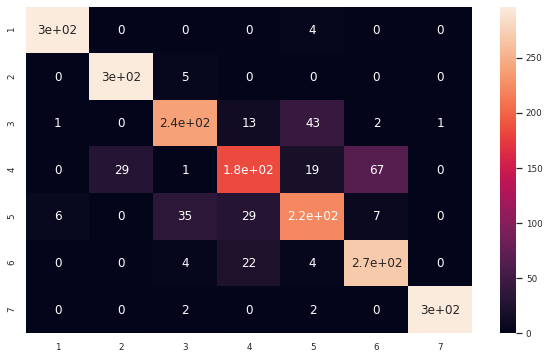



Accuracy Score Combined:  0.8590476190476191

Classification Report COMBINED:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       300
           1       0.91      0.98      0.95       300
           2       0.84      0.80      0.82       300
           3       0.74      0.61      0.67       300
           4       0.76      0.74      0.75       300
           5       0.78      0.90      0.84       300
           6       1.00      0.99      0.99       300

    accuracy                           0.86      2100
   macro avg       0.86      0.86      0.86      2100
weighted avg       0.86      0.86      0.86      2100



In [0]:
#-------------Confusion Matrix COMBINED---------------------

conf_matrix_comb = confusion_matrix(Y_test, total_pred)
print("Confusion Matrix for Combined:\n")
df_cm_shape = pd.DataFrame(conf_matrix_comb, index = [i for i in "1234567"],
                      columns = [i for i in "1234567"])
plt.figure(figsize = (10,6))
sns.set(font_scale=0.8)
subplot = sns.heatmap(df_cm_shape, annot=True,annot_kws={"size": 12})# font size
subplot.set_ylim(7, 0)
plt.show()
#------------Accuracy Score COMBINED------------------------
print("\n\nAccuracy Score Combined: ", (accuracy_score(Y_test, total_pred)))
print("\nClassification Report COMBINED:\n", (classification_report(Y_test, total_pred)))

# GaussianMLE

In [0]:
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin

epsilon = 1e-7

class GaussianMLE(BaseEstimator, ClassifierMixin):
  def __init__(self):
    self.p_w_i = []
    self.mi = []
    self.sigma = []
    self.inv_sigma = []
    self.amplitudes = []

  def fit(self, x_train, w_train):
    x_train = np.array(x_train)
    w_train = np.array(w_train)

    # Cria grupos da mesma classe no dataset.
    num_samples = len(w_train)
    num_classes = len(np.unique(w_train))
    x_groups = list(map(
      lambda label_k:
        np.array(
          [x_train[i] for i in range(num_samples) if w_train[i] == label_k]
        ),
      range(num_classes),
    ))

    # Estima a probabilidade a priori para cada classe.
    classes, counts = np.unique(w_train, return_counts=True)
    num_classes = len(classes)
    self.p_w_i = np.array(list(map(
      lambda label_k: counts[label_k]/float(num_classes),
      range(num_classes),
    )))

    # Estima a média e variancia diagonal para cada classe
    self.mi = np.array(list(map(
      lambda x_train_i: np.mean(x_train_i, axis=0),
      x_groups,
    )))

    n = len(self.mi)
    self.sigma = np.array(list(map(
      lambda i: np.mean((x_groups[i] - self.mi[i])**2, axis=0) * 1/n,
      range(len(x_groups)),
    )))

    # Pre-computa constantes.
    pi_const = np.power(2*np.pi, n)
    det_sigma = np.abs(np.product(self.sigma, axis=1))
    self.inv_sigma = 1.0/(self.sigma + epsilon)
    self.amplitudes = 1.0/(np.sqrt(pi_const * (det_sigma + epsilon)))

    return self

  def predict(self, x_set):
    x_set = np.array(x_set)
    def classify(x):
      p_x_wi = self.compute_likelihoods(x)
      return np.argmax(p_x_wi * self.p_w_i)

    return np.array(list(map(classify, x_set)))

  def compute_a_priori(self):
    return self.p_w_i

  def compute_a_posteriori(self, x):
    """
    Computes the a posteriori probability p(wi|x) for each class wi, given by:
      p(wi|x) = [p(x|wi)p(wi)] / sum_k(p(x|wk)p(wk))
    """
    # Likelihood: p(x|wi).
    p_x_wi = self.compute_likelihoods(x)
    # A priori probability: p(wi).
    p_wi = self.p_w_i
    # Joint proability p(x && wi).
    p_x_and_wi = p_x_wi * p_wi

    return p_x_and_wi / np.sum(p_x_and_wi + epsilon)

  def predict_proba(self, x_set):
    x_set = np.array(x_set)
    return np.array(list(map(self.compute_a_posteriori, x_set)))

  def compute_likelihoods(self, x):
    A = self.amplitudes
    mi, sigma_inv = self.mi, self.inv_sigma
    return A * np.exp(-0.5 * np.sum(sigma_inv * (x - mi)**2, axis=1))

**GaussianMLE Execução**

In [0]:
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

shape_acc = 0.0
shape_clf = None

for train_index, test_index in kfold.split(X_shape, Y_train):
  X_train, X_test = X_shape.iloc[train_index,:], X_shape.iloc[test_index,:]
  y_train, y_test = Y_train[train_index], Y_train[test_index]
  
  g_mle_shape = GaussianMLE().fit(X_train, y_train)

  predictions = g_mle_shape.predict(X_test)
  accuracy = accuracy_score(y_test, predictions)

  if accuracy > shape_acc:
    shape_clf = g_mle_shape
    shape_acc = accuracy

rgb_acc = 0.0
rgb_clf = None

for train_index, test_index in kfold.split(X_rgb, Y_train):
  X_train, X_test = X_rgb.iloc[train_index,:], X_rgb.iloc[test_index,:]
  y_train, y_test = Y_train[train_index], Y_train[test_index]

  g_mle_rgb = GaussianMLE().fit(X_train, y_train)

  predictions = g_mle_rgb.predict(X_test)
  accuracy = accuracy_score(y_test, predictions)

  if accuracy > rgb_acc:
    rgb_clf = g_mle_rgb
    rgb_acc = accuracy
  
Y_pred_shape = shape_clf.predict(Shape_test)
Y_pred_rgb = rgb_clf.predict(Rgb_test)

Confusion Matrix for shape:



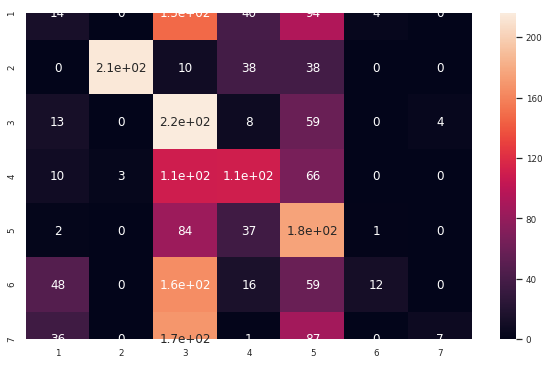



Accuracy Score Shape:  0.35714285714285715

Classification Report SHAPE:
               precision    recall  f1-score   support

           0       0.11      0.05      0.07       300
           1       0.99      0.71      0.83       300
           2       0.24      0.72      0.36       300
           3       0.44      0.37      0.40       300
           4       0.30      0.59      0.40       300
           5       0.71      0.04      0.08       300
           6       0.64      0.02      0.05       300

    accuracy                           0.36      2100
   macro avg       0.49      0.36      0.31      2100
weighted avg       0.49      0.36      0.31      2100



Confusion Matrix for RGB:



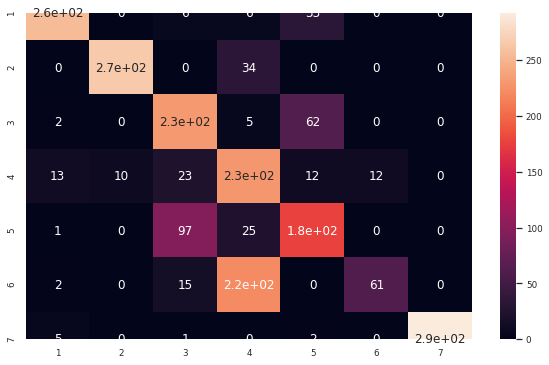

Accuracy Score RGB:  0.72

Classification Report RGB:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88       300
           1       0.96      0.89      0.92       300
           2       0.62      0.77      0.69       300
           3       0.44      0.77      0.56       300
           4       0.62      0.59      0.60       300
           5       0.84      0.20      0.33       300
           6       1.00      0.97      0.99       300

    accuracy                           0.72      2100
   macro avg       0.77      0.72      0.71      2100
weighted avg       0.77      0.72      0.71      2100



In [0]:
#-------------Confusion Matrix SHAPE---------------------

conf_matrix_shape = confusion_matrix(Y_test, Y_pred_shape)
print("Confusion Matrix for shape:\n")
df_cm_shape = pd.DataFrame(conf_matrix_shape, index = [i for i in "1234567"],
                      columns = [i for i in "1234567"])
plt.figure(figsize = (10,6))
sns.set(font_scale=0.8)
sns.heatmap(df_cm_shape, annot=True,annot_kws={"size": 12})# font size
subplot.set_ylim(7, 0)
plt.show()
#------------Accuracy Score SHAPE------------------------
print("\n\nAccuracy Score Shape: ", (accuracy_score(Y_test, Y_pred_shape)))
print("\nClassification Report SHAPE:\n", (classification_report(Y_test, Y_pred_shape)))
 
# #-------------Confusion Matrix RGB---------------------
conf_matrix_rgb = confusion_matrix(Y_test, Y_pred_rgb)
print("\n\nConfusion Matrix for RGB:\n")
df_cm_rgb = pd.DataFrame(conf_matrix_rgb, index = [i for i in "1234567"],
                      columns = [i for i in "1234567"])
plt.figure(figsize = (10,6))
sns.set(font_scale=0.8)
sns.heatmap(df_cm_rgb, annot=True,annot_kws={"size": 12})# font size
subplot.set_ylim(7, 0)
plt.show()

# #------------Accuracy Score RGB------------------------
print("Accuracy Score RGB: ", (accuracy_score(Y_test, Y_pred_rgb)))
print("\nClassification Report RGB:\n", (classification_report(Y_test, Y_pred_rgb)))


In [0]:
combinedGaussian = CombinedClassifiers(g_mle_shape, g_mle_rgb, shape_view, rgb_view, 2, p_w)

In [0]:
total_pred = combinedGaussian.predict(test_dataset)

Confusion Matrix for Combined:



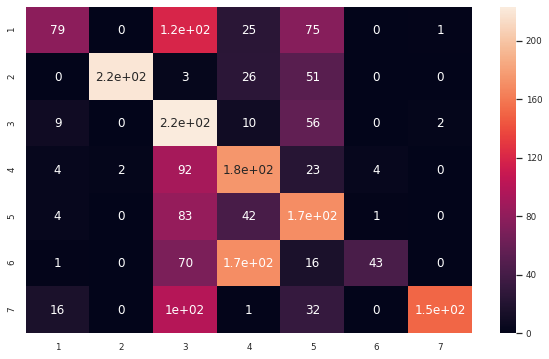



Accuracy Score Combined:  0.5052380952380953

Classification Report COMBINED:
               precision    recall  f1-score   support

           0       0.70      0.26      0.38       300
           1       0.99      0.73      0.84       300
           2       0.32      0.74      0.45       300
           3       0.39      0.58      0.47       300
           4       0.40      0.57      0.47       300
           5       0.90      0.14      0.25       300
           6       0.98      0.50      0.67       300

    accuracy                           0.51      2100
   macro avg       0.67      0.51      0.50      2100
weighted avg       0.67      0.51      0.50      2100



In [0]:
#-------------Confusion Matrix COMBINED---------------------

conf_matrix_comb = confusion_matrix(Y_test, total_pred)
print("Confusion Matrix for Combined:\n")
df_cm_shape = pd.DataFrame(conf_matrix_comb, index = [i for i in "1234567"],
                      columns = [i for i in "1234567"])
plt.figure(figsize = (10,6))
sns.set(font_scale=0.8)
subplot = sns.heatmap(df_cm_shape, annot=True,annot_kws={"size": 12})# font size
subplot.set_ylim(7, 0)
plt.show()
#------------Accuracy Score COMBINED------------------------
print("\n\nAccuracy Score Combined: ", (accuracy_score(Y_test, total_pred)))
print("\nClassification Report COMBINED:\n", (classification_report(Y_test, total_pred)))

In [0]:
total_pred_proba = combinedGaussian.predict_proba(test_dataset)

# **Wilcoxon rank test**

Vamos usar o teste de Wilcoxon para comparar os dois classificadores combinados do knn e gaussian

In [0]:
from scipy.stats import wilcoxon
from sklearn.model_selection import cross_val_score

stat, p = wilcoxon(resultsGaussian, resultsKNN)

print("-------- Gaussian x KNN --------")
print('Wilcoxon Statistics=%.3f, p=%.7f' % (stat, p))
#interpret
alpha = 0.05
  if p > alpha:
 	print('Same distribution (fail to reject H0)')
 else:
 	print('Different distribution (reject H0)')
